# Kunsten å senke Vasa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math

%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from time import time
from numpy.linalg import solve, norm

from scipy.optimize import curve_fit


Note: you may need to restart the kernel to use updated packages.


På 1600-tallet sank det svenske orlogsskipet Vasa på jomfruturen sin. Skipet kantret kort tid etter det satt seil, og oppfylte åpenbart ikke stabilitetskravene til et havsdyktig skip. Med utgangspunkt i dette skal vi lage en enkel skipsmodell og se på hvordan ulike faktorer påvirker stabiliteten og bevegelsen til et skip. Vi undersøker hvilke betingelser som vil lede til kantring, skipsdynamikken med last, og hvordan samspill av forskjellige krefter påvirker dynamikken. I hovedsak er det vinkelen og y_komponenten i skipets bevegelse vi undersøker og plotter, siden disse to gir oss betingelsen for kantring.

Koden vi skriver i dette prosjektet bygger på koden i ODE-notatet, med endringer og tillegg der det er nødvendig.



Vi bruker en relativ enkel modell. Skipet er halvsirkelformet, 2 dimensjonalt med en 
$$ radius: R = 10m. $$ 
og med en massetetthet $$ \rho = 500  \frac{kg}{m^{2}}. $$

Massesenteret, C til en halvsylinder med uniform masse ligger en avstand

$$ H = \frac{4R}{3\pi} \approx 0.42 R  (1)  $$

under skipets metasenter M.

Arealet av vannmengden skipet fortrenger ved likevekt vil av arkimedes love være.
$$ A_{0} = \frac{\rho \pi R^{2}}{2\rho_{0}} (2)$$
$$ \rho_{0} = 1000 \frac{kg}{m^{2}} $$
er vannets massetetthet.

Etterhvert som skipet begynner å rotere, vil $$ A_{0} $$  variere og avhenge av vinkelen $$\gamma$$. 


$$ A_{0} = \frac{1}{2} R^{2} (\gamma - sin \gamma)(3) $$


Figur 2 fra oppgavesettet, skipet etter en rotasjon $$\theta$$  om massesenteret.

B er angrepspunktet for det fortrengte vannet. B ligger 

$$ Y_{MB} = R \cdot \frac{4 sin^{3} \frac {\gamma}{2}}{3(\gamma-sin \gamma)} $$

under midtpunktet M.

D er skipets dypeste punkt, det vil alltid ligge rett under M.

$$ \gamma $$ er vinkelen fra M mellom punktene der båten møter vannflaten

Vannlinjen ligger fast langs $$ Y = 0 $$.

Når skipet roterer om C vil M forflytte seg

$$ \Delta y_{M} = H (\cos \theta - 1) $$

i horisontal retning.

B og D ligger rett under M, og vil derfor alltid forflytte seg like langt.

$$ \Delta y_{B} = \Delta y_{D} = \Delta y_{M} $$

In [2]:
#definerer variabler

g=9.81
pi=np.pi


rho_w = 1000  #kg/m^3 
rho_s = 500 #kg/m^2 massetetthet skip per lengdeenhet
R_s = 10  #m  radius skip
A_s = 1/2*pi*R_s**2
m_s = A_s*rho_s  #kg  masse per lengdeenhet
height = 4*R_s/(3*pi)  #skipets massesenter og avstand fra mellom C og M

I_c=0.5*m_s*R_s**2*(1-32/(9*pi**2))  #skipets treghetsmoment












1a)
Først starter vi med å kalkulere sektorvinkelen $$ \beta $$ ved likevekt.
Vi trenger da å løse likningen

$$ \beta - \sin \beta = \frac {\pi \rho}{\rho_{0}} $$.

Vi skriver om likningen til

$$ \beta= \frac {\pi \rho}{\rho_{0}}  + \sin \beta = g(\beta) $$

For å bruke fikspunktiterasjon trenger vi at følgende krav er oppfylt:

1: g $$ \epsilon C [A,B]  $$ og at $$ A < g(\beta) < B $$ for alle $$ x \epsilon [A,B] $$ For at løsningen vil konvergere mot et punkt.

2: Hvis det finnes en L slik at $$ \left | {g(\beta)}' \right |  \leq L < 1$$ vet vi at punktet er den eneste løsningen på intervallet.

Intervallet [A,B] vi ser på går fra A>0 til B<$$\pi$$. Der A er "litt" større enn 0 og B er "litt" mindre enn $$\pi$$. Ser vi på $$ g(\beta) $$ på dette intervallet vil den alltid ligge mellom $$[\frac {\pi \rho}{\rho_{0}},\frac {\pi \rho}{\rho_{0}}+1]$$ som når $$\frac {\rho}{\rho_{0}} = \frac{1}{2}$$ alltid vil ligge mellom [A,B]. Så første kravet er oppfyllt.

For andre kravet har vi:

$$ \left | {g(\beta)}' \right | = \left | \cos(\beta) \right | \leq L < 1$$

som stemmer for alle verdier $$\beta \epsilon [A,B] $$.


Koden under finner $\beta$ med fikspunktiterasjon:


In [3]:
# 1a)

def f_b(beta, rho_s, rho_0):
    return np.pi*rho_s/rho_w +np.sin(beta)

def fixed_point_it(it,x0):
    for i in range(it):
        x0 = f_b(x0,500, 1000)
        if (i == 99):
            x1=x0 #for usikkerhetsberegning
            print ("Nest siste steg: ", np.rad2deg(x1)) 
    return x0 , np.abs(x0-x1)
    
    
beta0, error = (fixed_point_it(100,2))
print ("beta = ", np.rad2deg(beta0))
print ("Error= ", error)

y_c0=R_s*np.cos(beta0/2)-height  #Regner ut høyden til massesenteret ved likevekt
A_vann = 0.5*R_s**2*(beta0 - np.sin(beta0)) #areal utestengt vann ved likevekt
#print(A_vann,A_s-A_vann)

Nest siste steg:  132.3464588340929
beta =  132.3464588340929
Error=  0.0


Vi bruker en "a-posteriori" usikkerhetsberegning $$ |x_{k+1}-x_{k}| $$ for å finne usikkerheten. Vi ser at etter 100 steg så er usikkerheten $$ e_{100} \approx 0 $$. Usikkerheten ligger etter det 14 desimalet.

Vi fikk $$\beta = 132.3^{\circ} $$ 

1 b) 

Vi skal nå regne ut posisjonen til skipets metasenter $$ y_{M}^{0} $$, massesenter $$ y_{C}^{0}  $$, angrepspunktet for oppdriften $$ y_{B}^{0}  $$ og skipets dypeste punkt $$ y_{D}^{0}  $$ ved likevekt i forhold til vannoverflaten.

$$ y_{M}^{0} = R \cos \frac {\beta}{2} $$

$$ y_{C}^{0} = R \cos \frac {\beta}{2} - \frac{4R}{3\pi} $$

$$ y_{B}^{0} = R \cos \frac {\beta}{2} - 4R \sin^{3}( \frac{\beta}{2}) \frac {1}{3(\beta - \sin \beta)} $$

$$ y_{D}^{0} = R \cos \frac {\beta}{2} - R $$






In [4]:
# 1b)

y_M0 = R_s * np.cos(beta0/2) #Høyden til metasenteret

y_C0 = R_s * np.cos(beta0/2) - 4*R_s / (3*np.pi) #Høyden til massesenteret

y_B0 = R_s * np.cos(beta0/2) - 4*R_s * np.sin(beta0/2)**3*(beta0/2)*1/(3*(beta0-np.sin(beta0))) #Høyden til angrepspunktet for oppdriftskraften

y_D0 = R_s*np.cos(beta0/2) - R_s #Høyden til det dypeste punktet

print ("Høydene ved likevekt")
print("Høyde til metasentert: ", y_M0)
print ("Høyde til massesenteret: ", y_C0)
print ("Høyde til oppdriftens angrepspunkt: ", y_B0)
print ("Høyde til det dypestepunktet: ", y_D0)


Høydene ved likevekt
Høyde til metasentert:  4.039727532995173
Høyde til massesenteret:  -0.20440428278870204
Høyde til oppdriftens angrepspunkt:  -3.464668523303949
Høyde til det dypestepunktet:  -5.960272467004827


Det er mye interessant i høydene vi har regnet ut. Metasenteret $$y_{M}^0$$ til skipet befinner seg høyt over havet. Dypeste $$y_{D }^0$$ punktet til skipet er derfor ikke veldig dypt. Og Massesenteret  $$y_{C}^0$$ til skipet befinner seg nesten opp under vannoverflaten. 

Avstanden fra $$y_{M}^0$$  til $$y_{C}^0$$ er relativt stor, noe som gjør båten mer stabil ved at dreiemomentet $$\tau_{B}$$ fra oppdriften får en lenger arm når skipet roterer. Siden angrepspunktet til oppdriften $$y_{B }^0$$ alltid befinner seg rett under metasenteret.


Nå er vi klare til å undersøke skipet i bevegelse. I første omgang neglisjerer vi bevegelsen til massesenteret og antar at mengden fortrengt vann ikke endrer seg. Det betyr at $$F_B = -F_G$$, og kun dreimomentet  $$\tau_B$$  får skipet til å bevege seg. Det vil si at vi har en ren rotasjonsbevegelse. For å simulere den tar vi inn arrayen $\vec{w}(t)$ i ODE_solver-funksjonen vår. Under finner vi $\vec{f}(t)$ og viser hvorfor vi kan skrive om ligningen til $\frac{d\vec{w}}{dt} = \vec{f}(t, \vec{w})$

1c)


$$ \vec{w}(t) = [\theta (t), w(t)]^T$$  

$$ \frac{ d \vec{w}}{dt} = \vec{f}(t,\vec{w})$$ 


Ligning 13 sier $$ \Sigma \tau = I_C \frac{dw}{dt} $$. Nå når vi kun ser på rotasjon om C uten friksjon kan vi skrive dette som 

$$\tau_B = I_c \frac{dw}{dt}  \Rightarrow \frac{dw}{dt} = \frac{\tau_B}{I_C} = \frac{-F_B h \sin{\theta}}{I_C}$$

Da har vi $$\frac{ d \vec{w}}{dt} = [\frac{ d \theta}{dt}, \frac{ dw}{dt}]^T = [w, \frac{-F_B h \sin{\theta}}{I_C}]^T$$

$$\Rightarrow$$

$$ \vec{f}(t,\vec{w}) = [\vec{w}[1], \frac{-F_B h \sin{\vec{w}[0]}}{I_C}]^T$$ 




Nå som vi har et utrykk for difrensiallikningen kan vi bruke Eulers metode for å løse den.



Da har vi det vi trenger for å begynne med numeriske beregninger. Under definerer vi Euler-metoden og ode_solver fra ODE-notatet, i tillegg til dreiemomentfunksjonen som returnerer den deriverte av $\vec{w}$

Vi simulerer bevegelsen med steglengder 0.01, 0.001 og 0.0001

økning i amplitude med h = 0.01 :  2.669471517801014
økning i amplitude med h = 0.001 :  0.25216255277724997
økning i amplitude med h = 0.0001 :  0.025074398375537044


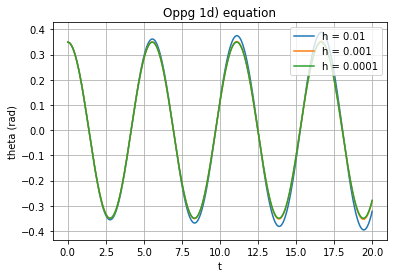

In [6]:
def euler(f, t, y, h):
    # One step of the Euler method
    y_next = y + h*f(t, y)
    t_next = t + h
    return t_next, y_next

def ode_solver(f, t0, tend, y0, h, method=euler):
    time_start = time()

    #Initializing:
    y_num = np.array([y0])    # Array for the solution y 
    t_num = np.array([t0])    # Array for the x-values

    tn = t0                # Running values for x and y
    yn = y0 

    # Main loop
    while tn <= tend:           # Buffer for truncation errors        
        tn, yn = method(f, tn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = np.concatenate((y_num, np.array([yn])))
        t_num = np.append(t_num,tn)
    return t_num, y_num

def f_1d(t, array):

    
    torque = -A_vann*rho_w*g*height*np.sin(array[0])
    
    dy = np.array([array[1], torque/I_c])

    return dy
t0_1d, tend_1d = 0, 20            # tids intervall

w_vector_d = np.array([np.radians(20),0])        # start verdier

# Solve the equation
t_1d, array_1d = ode_solver(f_1d, t0_1d, tend_1d, w_vector_d, h=0.01)
t_1d2, array_1d2 = ode_solver(f_1d, t0_1d, tend_1d, w_vector_d, h=0.001)
t_1d3, array_1d3 = ode_solver(f_1d, t0_1d, tend_1d, w_vector_d, h=0.0001)


def get_theta(array): #Funksjon for å hente ut theta-verdien fra funksjonsarrayen
    theta_array = np.zeros(len(array))
    for i in range(len(array)):

        theta_array[i] = array[i][0]
    return theta_array

theta_1d = get_theta(array_1d) #henter ut theta verdien
theta_1d2 = get_theta(array_1d2)
theta_1d3 = get_theta(array_1d3)
print("økning i amplitude med h = 0.01 : ", np.rad2deg(np.amax(np.abs(theta_1d)))-20)
print("økning i amplitude med h = 0.001 : ", np.rad2deg(np.amax(np.abs(theta_1d2)))-20)
print("økning i amplitude med h = 0.0001 : ",np.rad2deg(np.amax(np.abs(theta_1d3)))-20)

plt.plot(t_1d, theta_1d);
plt.plot(t_1d2, theta_1d2)
plt.plot(t_1d3, theta_1d3)
plt.legend(["h = 0.01", "h = 0.001", "h = 0.0001"],loc = 1)
plt.grid()
plt.ylabel("theta (rad)")
plt.xlabel('t')
plt.title('Oppg 1d) equation')
plt.show()




Vi ser at $\theta$ - plottet er tilnærmet lik en cosinusfunksjon. Dette er ikke overraskende, siden uttrykkets analytiske løsning vil være en cosinusfunksjon dersom vi bruker småvinkelapproksimasjonen

Vi ser at alle funksjonene fører til at amplituden øker med en viss mengde. Siden dreiemomentet er like stort og motsatt rettet for $\theta$ over og under null vet vi at amplituden egentlig ikke skal endre seg. Det vil si at denne økningen er feilen vår. Vi ser at feilen er proporsjonal med steglengden, som forventet av en første ordens metode

Vi velger h = 0.001, etttersom den ga en relativ liten feil og kort kjøretid.


Nå prøver vi småvinkelapproksimasjonen og sammenligner med metoden over. Dette er interessant fordi vi kan vurdere hvor god approksimasjonen er for forskjellige vinkler, i tillegg til at vi nå har en analytisk løsning vi kan sammenligne med.
Dette gjør vi enkelt nok ved å definere en ny dreimomentfunksjon med $\theta$ istedenfor $\sin{\theta}$ som vi kaller på i ode_solver.

Vi tester først approksimasjonen med $\theta_0 = 20^\circ$, så med $\theta_0 = 1^\circ$

Max value for sin(x) = x estimation:  20.252475881844596
Max value no estimation:  20.25216255277725
Difference in last value:  0.042060494864943454


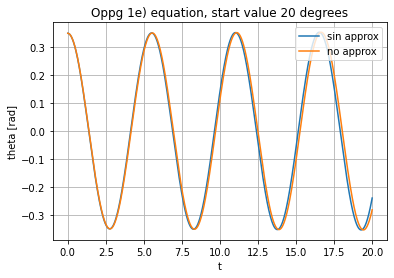

In [7]:


def f_approx(t, array): #lager en funksjon med sin(x)=x tilnærming
    torque = -A_vann*rho_w*g*height*array[0]
    
    dy = np.array([array[1], torque/I_c])

    return dy



t_1d , array_1d = ode_solver(f_1d, t0_1d, tend_1d, w_vector_d, h=0.001) #Løser difflikningene

t_1e, array_1e = ode_solver(f_approx, t0_1d, tend_1d, w_vector_d, h=0.001)



theta_1d = get_theta(array_1d)

print("Max value for sin(x) = x estimation: ",np.rad2deg(np.amax(np.abs(array_1e[:,0]))))
print("Max value no estimation: ", np.rad2deg(np.amax(np.abs(theta_1d))))

plt.plot(t_1e, array_1e[:,0]);

plt.plot(t_1d, theta_1d);


plt.grid()
plt.xlabel('t')
plt.ylabel("theta [rad]")
plt.title('Oppg 1e) equation, start value 20 degrees')
plt.legend(['sin approx','no approx'],loc=1);

print("Difference in last value: ", np.abs(array_1e[:,0][-1]-theta_1d[-1]))
    

 Vi ser at sin(x) = x gir greie resultater for $$ \theta_{0} = 20^{\circ} $$, men at det ikke er en perfekt tilnærming  Grunnentil dette er at feilen til tilnærmingen $$ \sin(20^{\circ}) = \sin(0.349) = 0.342 < 0.349 $$ på det meste er $$ \approx 2\% $$ feil.
Vi ser at etter 20 sekunder med steglengde h = 0.001 har sinus approksimasjonen driftet 0.042 rad = $$ 2.41^{\circ} $$ feil.

Max value for sin(x) = x estimation:  1.0126237940922391
Max value without estimation:  1.0126236054935494
Difference in last value:  5.761340816607535e-06


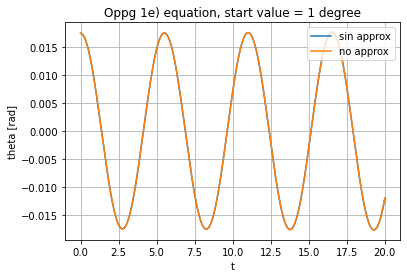

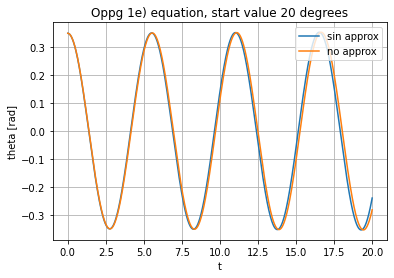

In [8]:



w_vector_estimate = np.array([np.radians(1),0]) #setter startvinkelen til 1 rad.

t_1e_est, array_1e_estimate = ode_solver(f_approx, t0_1d, tend_1d, w_vector_estimate, h=0.001) 

t_1e_no_est, array_1e_not_estimate = ode_solver(f_1d, t0_1d, tend_1d, w_vector_estimate, h=0.001) 

theta_1e_estimate = get_theta(array_1e_estimate)
theta_1e_exact = get_theta(array_1e_not_estimate)



print("Max value for sin(x) = x estimation: ",np.rad2deg(np.amax(np.abs(theta_1e_estimate))))
print ("Max value without estimation: ", np.rad2deg(np.amax(np.abs(theta_1e_exact))))
print("Difference in last value: ", np.abs(theta_1e_estimate[-1]-theta_1e_exact[-1]))
plt.plot(t_1e_est, theta_1e_estimate);

plt.plot(t_1e_no_est, theta_1e_exact);

plt.grid()
plt.xlabel('t')
plt.ylabel("theta [rad]")
plt.title('Oppg 1e) equation, start value = 1 degree')
plt.legend(['sin approx','no approx'],loc=1);
plt.show()

plt.plot(t_1e, array_1e[:,0]);

plt.plot(t_1d, theta_1d);


plt.grid()
plt.xlabel('t')
plt.ylabel("theta [rad]")
plt.title('Oppg 1e) equation, start value 20 degrees')
plt.legend(['sin approx','no approx'],loc=1);
plt.show()
    


Som forventet er tilnærmingen mye bedre for denne lille vinkelen. Her har vi $$\sin(1^{\circ}) = sin (0.0174532925) =0.01745240643$$. Som er en feil på 0.005 %. Vi ser at sin (x) = x er en veldig god tilnærming når $$ x<1^{\circ}$$Avviket i det siste punktet er på $$5.76*10^{-6} rad = 0.00033^{\circ} $$ 



Euler er som sagt en første ordens metode, nå går vi over til å bruke en fjerde ordens runge-kutta metodet. Denne metoden vil gi betraktelig mer presise resultater, på bekosting av litt lengre kjøretid. Ettersom funksjonen kalles på fire ganger per iterasjon. Under definerer vi RK4-funksjonen som fungerer på tilsvarende måte som Eulerfunksjnen

Under implementerer vi RK4 med samme betingelser som 1d

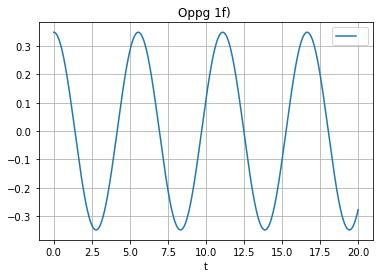

In [9]:
def RK4(f, t0, y0, h):
    
    k1 = f(t0, y0)
    k2 = f(t0 + h/2, y0 + h*k1/2)
    k3 = f(t0 + h/2, y0 + h*k2/2)
    k4 = f(t0 + h, y0 + h*k3)
    
    y_next = y0 + (h/6)*(k1 + 2*k2 + 2*k3 + k4) 
    t_next = t0 + h
    
    return t_next, y_next


   
w_vector_1f = np.array([np.radians(20), 0])
t0, tend = 0, 20
t_1f, array_1f = ode_solver(f_1d, t0, tend, w_vector_1f, h=0.01, method = RK4) 
theta_1f = get_theta(array_1f)


plt.plot(t_1f, theta_1f);
plt.grid()
plt.xlabel('t')
plt.title('Oppg 1f) ')
plt.legend(['',''],loc=1);

Nå som vi har to numeriske metoder av ulik orden er vi interessert i å sammenligne dem. Dette gjør vi ved å finne feilen deres i forhold til den analytiske løsningen vi får med småvinkelapproksimasjonen. Løsningen er relativ enkel å finne:

Med liten vinkel tilnærming har vi at 

$$ \frac{d^{2}\theta}{dt^{2}} = - \frac{F_{B}h\theta}{I_{c}} $$

som er en diffrensialikning som vi kan løse analytisk, vi får da:

$$ \ddot{\theta} = - \frac{F_{B}h\theta}{I_{c}} $$

$$ \ddot{\theta} + \frac{F_{B}h}{I_{c}}\theta = 0 $$

som er likningen for en enkel, harmonisk oscilator 

$$ \tilde{\theta}(t) = A \cos(\omega_{0}t+\phi) $$

med $$ \omega_{0} = \sqrt{\frac{F_{B}h}{I_{c}}} $$

med initialbetingelsene $$\omega(t=0) = 0 \frac{rad}{s} $$ og $$\theta(t=0)=0.01rad$$ får vi:

$$ {\tilde{\theta}}'(0) = - A \sin(\omega_{0}*0+\phi)*\omega_{0} = 0  $$

$$ A \neq 0 $$ og $$ \omega_{0} \neq 0 $$ så 

$$ \Rightarrow \phi=0$$ 

$$ \tilde{\theta}(0) = A \cos(\omega_{0}*0)  = 0.01rad$$

$$ \Rightarrow A=0.01rad$$ 

Vi får da likningen:

$$ \tilde{\theta}(t) = 0.01 \cos(\omega_{0}t) $$

med $$ T = \frac{2\pi}{\omega_{0}} = \frac{2\pi}{\sqrt{\frac{F_{B}h}{I_{c}}}} $$



Vi kan nå med den analytiske løsningene finne et feilestimat for metodene våre.

Analytisk T =  5.507316438523463


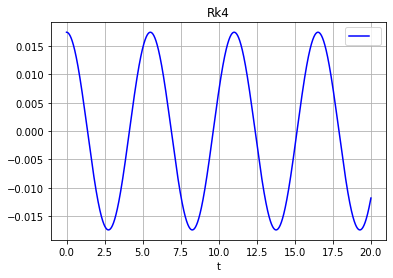

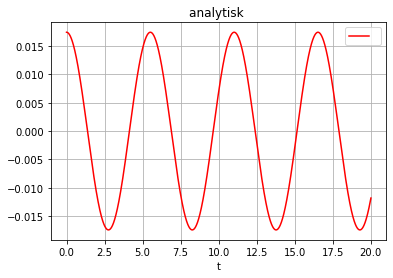

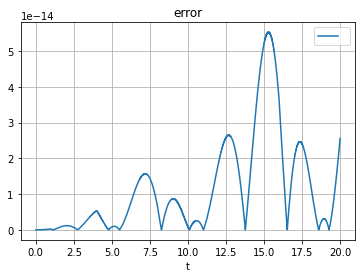

Max error 5.527999932808392e-14


In [10]:
#1g småvinkel approksimasjon av 1f
tend=20
w_vector_1g = np.array([np.radians(1), 0])
t_1g, array_1g = ode_solver(f_approx, t0, tend, w_vector_1g, h=0.001, method = RK4) 
theta_1g = get_theta(array_1g)

#analytisk løsning:

def analytic_1g(t, theta0):
    K = np.sqrt(A_vann*rho_w*g*height/I_c)
    A = theta0
    return A* np.cos(K*t)

g_analytic = analytic_1g(t_1g, np.radians(1))

print("Analytisk T = ",2*np.pi*1/(np.sqrt(A_vann*rho_w*g*height/I_c)) )


plt.plot(t_1g, theta_1g,'b');
plt.grid()
plt.title('Rk4')
plt.xlabel('t')
plt.legend(['',''],loc=1);
plt.show()

plt.plot(t_1g, g_analytic,'r');


plt.xlabel('t')
plt.grid()
plt.title('analytisk ')
plt.legend(['',''],loc=1);
plt.show()

error_1g =  abs(theta_1g - g_analytic)
plt.plot(t_1g, error_1g)
plt.xlabel('t')
plt.grid()
plt.title('error')
plt.legend(['',''],loc=1);
plt.show()

print ("Max error", np.amax(error_1g))

Feilestimat RK4:
Med en kjøretid på under 2 sekunder når h=0.001. Og numerisk feil i området $$ 10^{-13} $$ 

RK4 er tydelig en nøyaktig metode. Nå gjør vi en mer omfattende analyse av feilen i RK4-metoden som funksjon av steglengden, og sammenligner det med Eulermetoden.

Vi ser på den lokale feilen i et gitt punkt, t = 20. Og vi plotter feilen i dette punktet som en funksjon av steglengden for begge metodene. Vi lager en tilpasset ODE_solver som sørger for at de numeriske løsningene evaluerer $\vec{w}$ akkurat t = 20.
Vi ser på 1500 steglengdeer mellom 0.001 og 0.1.

In [11]:
# 1h)

def ode_solver2(f, t0, tend, y0, h, method=RK4): #denne sørger for at alle skrittlengdene evaluerer i t = 20 uansett
 

    #Initializing:
    y_num = np.array([y0])    
    t_num = np.array([t0])   

    tn = t0                
    yn = y0 

    # Main loop
    while tn < tend - 1.e-10:           
        if tn + h > tend: #Denne if-setningen sørger for at løsningen evaluerer i akkurat t = 20
            tn, yn = method(f, tn, yn, tend-tn) 
            y_num = np.concatenate((y_num, np.array([yn])))
            t_num = np.append(t_num,tn)
            
        else:
            tn, yn = method(f, tn, yn, h)    
            # Extend the arrays for x and y
            y_num = np.concatenate((y_num, np.array([yn])))
            t_num = np.append(t_num,tn)
            
    return t_num, y_num

h_vals_1h = np.linspace(0.1, 0.001, 1500)
y_1h = np.array([0.01, 0])
h_analytic = analytic_1g(20,0.01)

def h_we(num_method):
    
    error_list = []
    
    
    
    
    for i in range(1500):
        
        t_1h, array_1h = ode_solver2(f_approx, t0, tend, y_1h, h=h_vals_1h[i], method = num_method) 
        
        theta_1h = get_theta(array_1h)
        
        error_1h =  np.abs(theta_1h[-1] - h_analytic)
       
        error_list.append(error_1h)
        
      
        
    return error_list


error_list_euler = h_we(euler)


error_list_RK4 = h_we(RK4)


8.88333055074084e-05


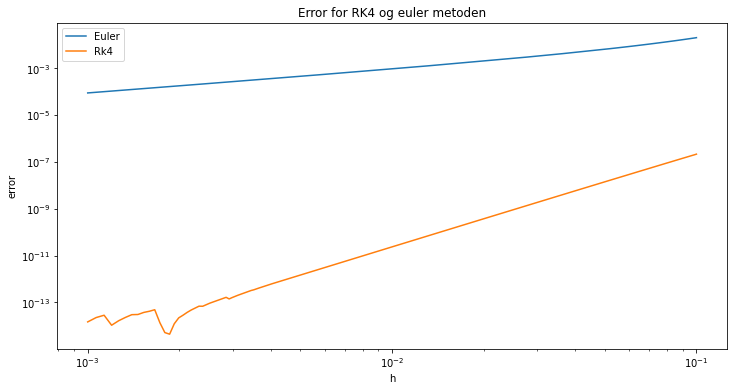

Stigningstall til log(euler_feil): 1.2423843124998761
Stigningstall til log(RK4_feil): 3.949473047040125


In [12]:
    
print(error_list_euler[-1])

plt.rcParams["figure.figsize"] = (12,6)

plt.loglog(h_vals_1h, error_list_euler)
plt.title('Error for RK4 og euler metoden')
    #plt.yscale('log')
plt.xlabel('h')
plt.ylabel('error')
#plt.show()

plt.loglog(h_vals_1h, error_list_RK4)
#plt.yscale('log')
plt.xlabel('h')
plt.ylabel('error')
plt.legend(['Euler', 'Rk4'])
plt.show()

def we(x,a,b):
    return a*x+b #definition of linear curve we need to use curve_fit

euler_fit, sleepy =  curve_fit(we,np.log(h_vals_1h),np.log(error_list_euler))

print("Stigningstall til log(euler_feil):",euler_fit[0])

RK4_fit, sleepy =  curve_fit(we,np.log(h_vals_1h),np.log(error_list_RK4))

print("Stigningstall til log(RK4_feil):", RK4_fit[0])

plt.rcParams["figure.figsize"] = (12,6)



I plotter ser vi feilen i t = 20 for RK4 og Eulermetoden plottet som funksjon av steglengde på en logaritmisk skala. Her er det litt å snakke om. RK4 har som forventet av en høyere ordens metode mye lavere feil enn Eulermetoden. At RK4 er hakkete i starten skyldes nok flytallsfeil, siden lagring av floats som nærmer seg 10^(-16) ikke er perfekt. 

Vi kan også bruke plottet til å bekrefte ordenen til plottene våre. Det gjør vi ved å bruke curve_fit fra scipy.optimize biblioteket. Den lar oss finne stigningstallet til en lineærtilnærming av grafer. Vi anvender denne på logaritmen av feilgrafene, som vi ser er tilnærmet lineære. Her forventer vi at logaritmen av grafen har stigningstall lik ordenen til metoden. Altså 1 for Euler og 4 for RK4. Som vi ser stemmer dette relativt godt, og vi kan si oss fornøyd med analysen

# Del 2 # 

Hittil har vi ikke latt mengden fortrengt vann variere. I denne delen tillater vi det, i tillegg til at vi etterhvert legger til last, friksjonskraft og bølgekraft.
Vi begynner med å kun bruke formlene i del 1, men lar nå fortengt vann variere.

Under definerer vi alle kreftene og dreiemomentene vi bruker i del 2.
Funksjonene er definert utifra likningene 14 og 15 oppgaveteksten. 

In [13]:




def f_g(m):
    #print('g',m*g)
    return -m*g

def A_vann2(gamma):  #Arealet fortrengt vann som varierer med gamma
    return 1/2*R_s**2*(gamma-np.sin(gamma))

def gamma(y_c,theta_val):  #sektorvinkel gamma som varierer med theta og dy_c
    return 2*np.arccos(y_c/R_s+(4/(3*pi))*np.cos(theta_val))

def gamma_laban(y_c,theta_val):  #sektorvinkel gamma som varierer med theta og dy_c
    return 2*np.arccos(y_c/R_s-(4/(3*pi))*(np.cos(1-theta_val))+beta/2)


def f_B(gamma_val):
    return A_vann2(gamma_val)* rho_w * g

def f_last_y(m_last, theta_val):
    return -m_last*g*(np.cos(theta_val))**2

def f_friction_x(gamma_val, vinkelfart,k_f):
    return k_f*R_s*gamma_val*vinkelfart

def f_waves_x(w_freq, F_0_wave, current_time):
    return F_0_wave*np.cos(w_freq*current_time)

def f_last_x(m_last, theta_val):
    return m_last*g*np.cos(theta_val)*np.sin(theta_val)

#t,y=ode_solver2(f_2atry, t0, tend, w_vector_start, h=0.01, method=RK4)
#plt.plot(t,y[:,0])
#plt.xlabel('t')
#plt.ylabel('$y_c$')
#plt.show()



In [14]:
#2d



def torque_B(gamma_val, theta_val):
    return - f_B(gamma_val)* height * np.sin(theta_val)

def torque_f(gamma_val, omega_val, theta_val, y_pos,k_f):
    return f_friction_x(gamma_val, omega_val,k_f)*(y_pos - (R_s*(np.cos(gamma_val/2))-1))

def torque_w(wave_fric, F_0_wave, current_time, y_pos):
    return f_waves_x(wave_fric, F_0_wave, current_time) * y_pos

def torque_last(m_last, theta_val, pos_last):
    return  -m_last*g*np.cos(theta_val)*pos_last

def torque_2d(gamma_val,theta_val, m_last, pos_last):
    return torque_B(gamma_val, theta_val) + torque_last(m_last,theta_val, pos_last)

def torque_complete(gamma_val,theta_val, m_last, pos_last, wave_fric, F_0_wave, current_time, y_pos, omega_val,k_f):
    return torque_B(gamma_val, theta_val) + torque_last(m_last,theta_val, pos_last) + torque_w(wave_fric, F_0_wave, current_time, y_pos) + torque_f(gamma_val, omega_val, theta_val,y_pos,k_f)




Vi implementerer funksjonen beskrevet i 2a. Denne funksjonen er en base for alle andre funksjon vi definerer i del 2.

Da er vi klare for første simulering i del 2. Her er betingelsen like som i 1d, men fortrengt vann varierer. Vi plotter den vertikale posisjonskomponenten til massesenteret.

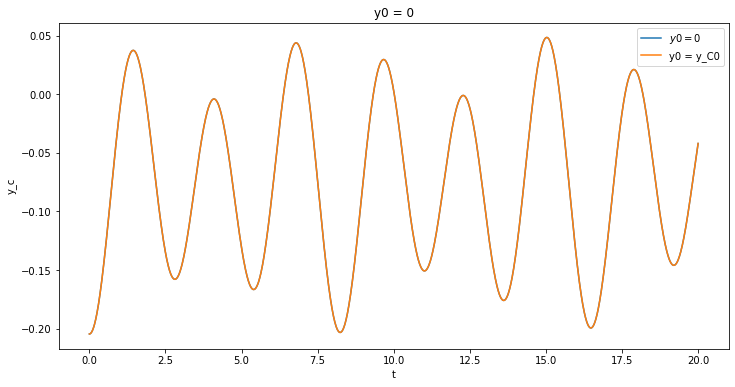

In [15]:
def f_2btry(t, array): #array med variabler vi ønsker å derivere
    #print(array)

    theta_val = array[0]
    #y_diff = - array[5] - y_c0 
    gamma_val = gamma(array[5],theta_val)
    #print(gamma_val)

  


    torque = torque_B(gamma_val, theta_val)

    #print(torque_B(gamma_val, theta_val))

    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_s) + f_B(gamma_val) 

    a_y = f_sum_y/m_s

    if gamma_val/2 > pi/2-abs(theta_val): #kantre betingelse
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, 0, a_y, v_x, v_y]) #returner en array med de deriverte av arrayen vi tok inn

        return dy


w_vector_start1=np.array([np.radians(20),0,0,0,0,y_C0])

t,y=ode_solver(f_2btry, t0_1d, 20, w_vector_start1, h=0.01, method=RK4)

plt.plot(t,y[:,5])
plt.title('y0 = 0')
plt.xlabel('t')
plt.ylabel('y_c')
w_vector_start2=np.array([np.radians(20),0,0,0,0,y_C0])

t2,y2=ode_solver(f_2btry, t0_1d, 20, w_vector_start2, h=0.01, method=RK4)

plt.plot(t2,y2[:,5])
plt.xlabel('t')
plt.legend(['$y0 = 0$','y0 = y_C0'])

plt.show()



Her har vi plottet y for 2 forskjellige startverdier av y
Vi ser at y-verdien til massesenteret ikke har en like ryddig harmonisk kurve som vinkelen. Oppførselen er mer kaotisk nå.

Vi ser at hver gang båten går dypt, er mengden fortrengt vann større og oppdriftskraften vokser som gir stor akselerasjon oppover, og vi får en høy bølgetopp.

Kantrebetingelsen er også lagt til i koden nå, som en if-setning som sjekker om en av skipets kanter ligger under vannoverflaten for hver iterasjon.

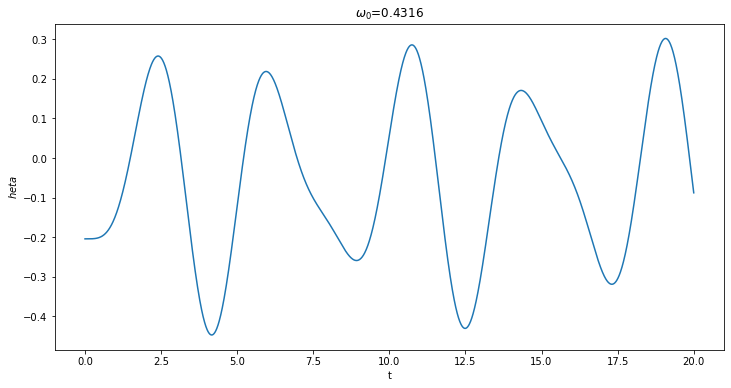

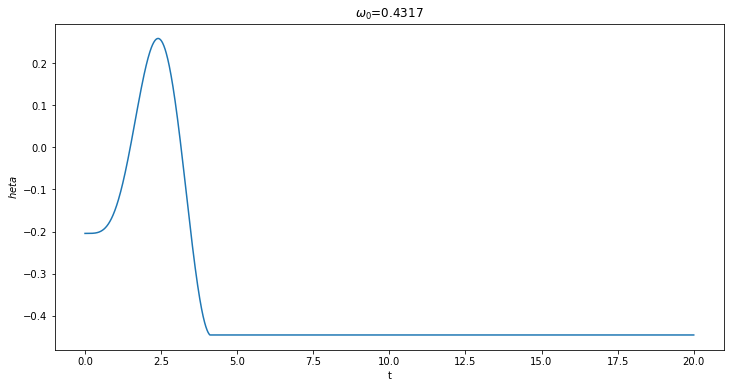

In [30]:
w_vector_start2c=np.array([0,0.4316,0,0,0,y_C0])

t2,y2=ode_solver(f_2btry, t0_1d, 20, w_vector_start2c, h=0.01, method=RK4)

plt.plot(t2,y2[:,5])
plt.xlabel('t')
plt.ylabel("$\theta$")
plt.title("$\omega_0$=0.4316")

plt.show()
w_vector_start2c=np.array([0,0.4317,0,0,0,y_C0])

t2,y2=ode_solver(f_2btry, t0_1d, 20, w_vector_start2c, h=0.01, method=RK4)


plt.plot(t2,y2[:,5])
plt.ylabel("v")
plt.ylabel("$\theta$")
plt.xlabel('t')
plt.title("$\omega_0$=0.4317")

plt.show()


Ved inspeksjon fant vi ut at båten kantrer et sted i intervallet $0.4316<\omega_0\leq 0.4317$.

Neste skritt er å legge til last på skipet. Dette kompliserer det ytterligere, men det innebærer bare å legge til lastens posisjon og fart i $ \vec{w}$, i tillegg til de relevante funksjonene av de vi definerte over. Vi legger også til en if-setning som setter massen lik null dersom lasten faller av (|s| > R), slik at den ikke påvirker bevegelsen etter det. 



In [17]:
#           0         1     2                      3                 4                          5                     6                7                       
#w_vektor=[tetta, omega, fart x_retning_båt, fart y_retning båt, posisjon x retning båt, posisjon y-retning båt,fart last på plan, posisjon last på plan]





def f_2d(t, array):
    global m_l
    m_tot = m_s + m_l
    s_last = array[7]
    theta_val = array[0]
    gamma_val = gamma(array[5],theta_val)

    if abs(array[7])>=R_s:
        v_last=0
        a_last=0
        m_l = 0
        m_tot = m_s + m_l

    else:
        v_last=array[6]
        a_last = - g*np.sin(theta_val)
        


    torque = torque_2d(gamma_val, theta_val, m_l, s_last)

    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_s) + f_B(gamma_val) + f_last_y(m_l, theta_val)

    a_y = f_sum_y/m_s
    #print(a_y)

    f_sum_x =  f_last_x(m_l, theta_val)
    a_x = f_sum_x/m_s


    if gamma_val/2 > pi/2-abs(theta_val):
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, a_x, a_y, v_x, v_y, a_last, v_last])

        return dy
    


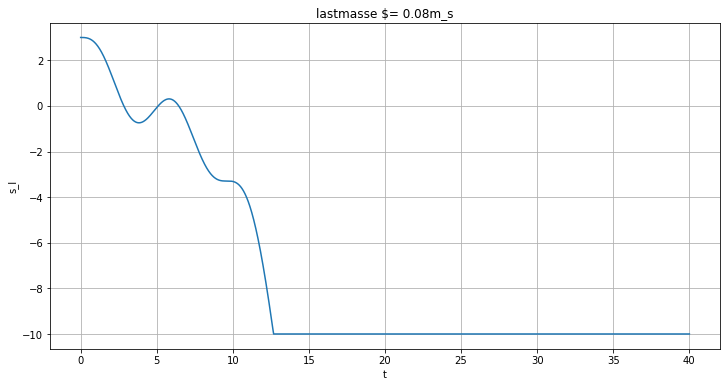

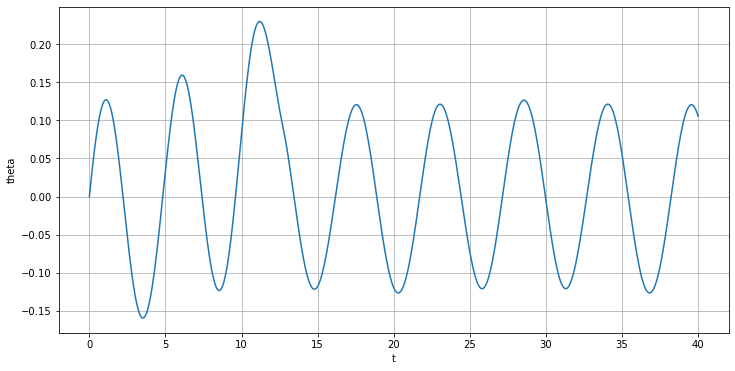

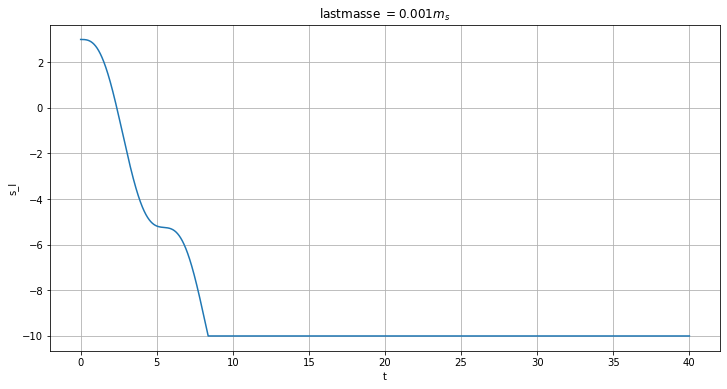

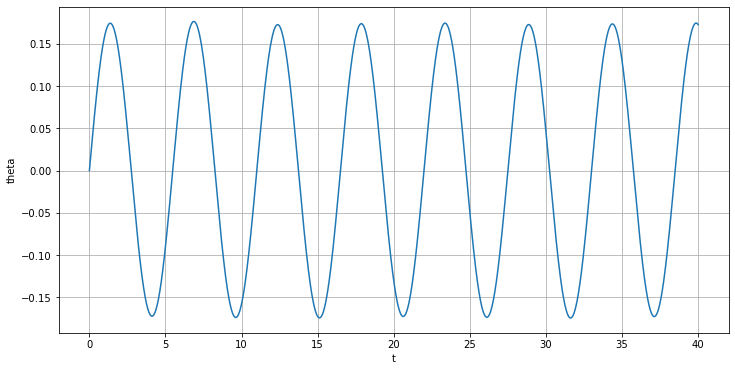

In [18]:
m_l=0.08*m_s
t0_try, tend_try = 0,40

w_vector_start1=np.array([0,0.2,0,0,0,y_C0,0,3])

t,y=ode_solver(f_2d, t0_try, tend_try, w_vector_start1, h=0.01, method=RK4)

plt.plot(t,y[:,7])
plt.title("lastmasse $= 0.08m_s")
plt.xlabel('t')
plt.ylabel('s_l')
plt.grid()
plt.show()

plt.plot(t,y[:, 0])
plt.grid()
plt.xlabel('t')
plt.ylabel('theta')
plt.show()

m_l=0.001*m_s

t,y=ode_solver(f_2d, t0_try, tend_try, w_vector_start1, h=0.01, method=RK4)

plt.plot(t,y[:,7])
plt.title("lastmasse $= 0.001m_s$")
plt.xlabel('t')
plt.ylabel('s_l')
plt.grid()
plt.show()

plt.plot(t,y[:, 0])
plt.grid()
plt.xlabel('t')
plt.ylabel('theta')
plt.show()



Her har lasten masse $ 0.08m_s $, og vi ser at det har en ganske stor innvirkning på skipets dynamikk. Vi ser fra lastens posisjonsgraf at den bytter retning ett par ganger, som følge av skipets rotasjon, som igjen delvis forårsakes av lasten. Når lasten faller av etter 13 sekunder cirka har det en tydelig innvirkning på vinkelutslaget, ettersom dreiemomentet fra lastens tyngde forsvinner.

Når lastmassen er en tusendel av skipets masse, ser vi at påvirkningen på vinkelutslaget er neglisjerbart. Lasten faller av relativt fort. Den blir ikke værende å snu fram å tilbake som man kanskje ville tenkt seg.

Det neste skrittet er å sørge for at lasten ikke faller av, men forblir på kanten når den glir dit. Vi bruker samme implementasjon som i forrige oppgave, bare at vi ikke setter massen lik null.

In [19]:
h_2e = 0.01
m_tot = m_s + m_l

def f_2e(t, array):
    s_last = array[7]
    theta_val = array[0]
    
    gamma_val = gamma(array[5],theta_val)
    a_last = - g*np.sin(theta_val)

    
    if abs(array[7]+h_2e*array[6]) > np.abs(10):
        v_last = (10 - abs(s_last))/h_2e *np.sign(array[6])  
    else:
        v_last = array[6]
    #print(a_last, theta_val)


    torque = torque_2d(gamma_val, theta_val, m_l, abs(s_last))


    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_s)+f_B(gamma_val)+f_last_y(m_l,theta_val)

    a_y = f_sum_y/m_s

    f_sum_x =  f_last_x(m_l, theta_val)
    a_x = f_sum_x/m_s

    
    if gamma_val/2 > pi/2-abs(theta_val):
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, a_x, a_y, v_x, v_y, a_last, v_last])

        return dy

t0_try_2e, tend_try_2e = 0,70

w_vector_start_e=np.array([0,0.1,0,0,0,y_C0,0,3])



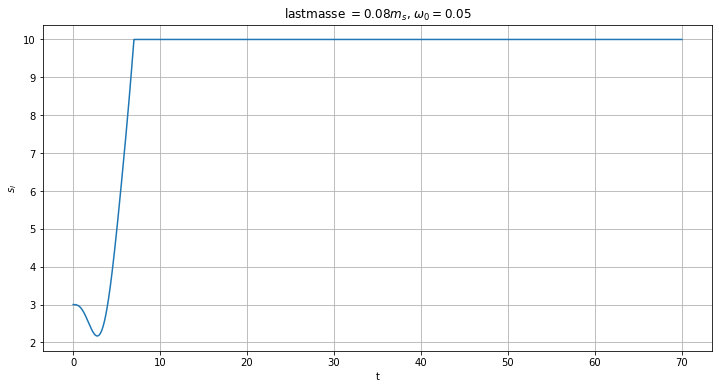

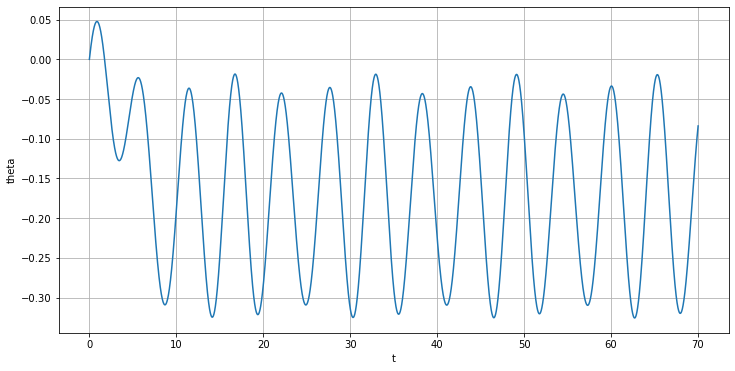

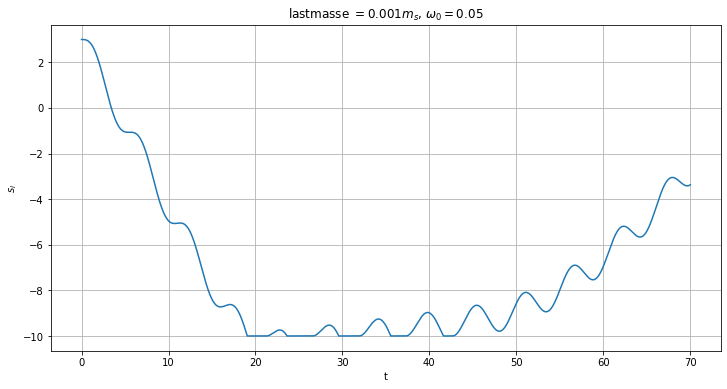

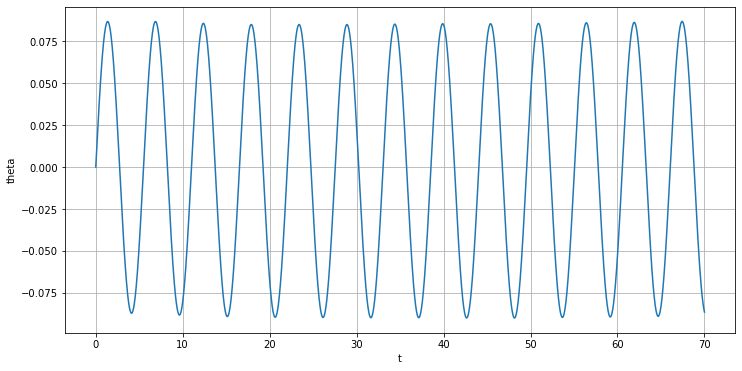

In [20]:
m_l=0.08*m_s

t,y=ode_solver(f_2e, t0_try_2e, tend_try_2e, w_vector_start_e, h=0.01, method=RK4)

plt.plot(t,y[:,7])
plt.title("lastmasse $= 0.08m_s$, $\omega_0 = 0.05$")
plt.xlabel('t')
plt.ylabel('$s_l$')
plt.grid()
plt.show()

plt.plot(t,y[:, 0])
plt.grid()
plt.xlabel('t')
plt.ylabel('theta')
plt.show()

m_l=0.001*m_s


t,y=ode_solver(f_2e, t0_try_2e, tend_try_2e, w_vector_start_e, h=0.01, method=RK4)

plt.plot(t,y[:,7])
plt.title("lastmasse $= 0.001m_s$, $ \omega_0 = 0.05$")
plt.xlabel('t')
plt.ylabel('$s_l$')
plt.grid()
plt.show()

plt.plot(t,y[:, 0])
plt.grid()
plt.xlabel('t')
plt.ylabel('theta')
plt.show()





I plottet til den tunge massen ser vi at den etter kort tid, glir til kanten og blir der. Skipet fortsetter og oscillere, men hele tiden med $\theta < 0$, slik at lasten ikke lar seg rikke fra kanten. Skipet kantrer dog ikke selv om systemet er i ubalanse. 

Den lille massen får en annerledes dynamikk. Vi ser at vinkelutslaget ikke blir særlig påvirket av at lasten er der, og oscillerer omtrent som vanlig. Lastens akselerasjon oscillerer med vinkelen, og beveger seg deretter. Vi ser at lasten ikke er tung nok til å bli på kanten som i forrige tilfellet. Når lastens er på kanten har massen har fått skipet til å synke litt mer på den siden, som igjen gjør at dreiemomentet fra oppdriftskraften er litt sterkere, dette fører til et litt sterkere vinkelutslag, som sakte men sikkert gjør at lasten snur.

Vi ser med den lille lastmassen at lasten relativt fort fester seg i gjerdet, men at den ikke er tung nok til å forårsake kantring, og bevegelsen går ganske som vanlig etter det.

Nå legger vi til de to siste gjenværende kreftene, friksjonskraft og bølgekraft. Det er som i stad ikke veldig omfattende, vi må bare legge til funksjonene som uttrykker ny kraft og dreimoment. I første omgang setter vi bølgekraften lik null slik at vi kun ser på friksjonens påvirkning på bevegelsen.

In [21]:
def f_2f_try(t, array):
    m_l=0*m_s
    m_tot = m_s + m_l
    #print(array)
    s_last = array[7]
    theta_val = array[0]

    w_freq = 0.93*np.sqrt(m_s*g*height/I_c) #frekvensen til innkommende bølge Rad/s
    F_0_wave = 0.0*m_s*g  #kraften fra bølgene


    y_diff = array[5] - y_c0
    #print(y_diff)
    gamma_val = gamma(array[5],array[0])
    

    if abs(array[7])>=R_s:
        m_l = 0
        
    else:
        v_last=array[6]
        a_last = - g*np.sin(theta_val)


    current_time = t
    y_pos=array[5]
    omega_val = array[1]

    torque = torque_complete(gamma_val,theta_val, m_l, s_last, w_freq, F_0_wave, current_time, y_pos, omega_val, k_friction,)

    #print(torque_B(gamma_val, theta_val))

    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_tot) + f_B(gamma_val) + f_last_y(m_l, array[0])
    

    a_y = f_sum_y/m_tot
    #print(a_y)

    f_sum_x =  f_last_x(m_l, theta_val) + f_waves_x(w_freq, F_0_wave, current_time) + f_friction_x(gamma_val, omega_val,k_friction)
    a_x = f_sum_x/m_tot

    r_last = s_last/np.cos(theta_val) #avstand fra massesenter til last

    #tar ikke høyde for at massesenteret flytter seg litt for da vil alle uttrykkene for dreiemoment endre seg

    
    if gamma_val/2 > pi/2-abs(theta_val):
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, a_x, a_y, v_x, v_y, 0, 0])

        return dy

t0_try, tend_try = 0,240

#           0         1     2                      3                 4                          5                     6                7                       
#w_vektor=[tetta, omega, fart x_retning_båt, fart y_retning båt, posisjon x retning båt, posisjon y-retning båt,fart last på plan, posisjon last på plan]
w_vector_oppg2e=np.array([0,0.4,0,0,0,y_C0,0,0])


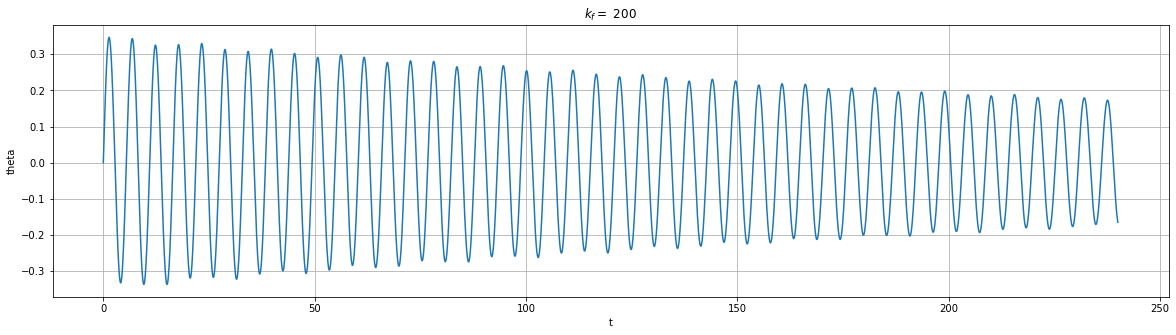

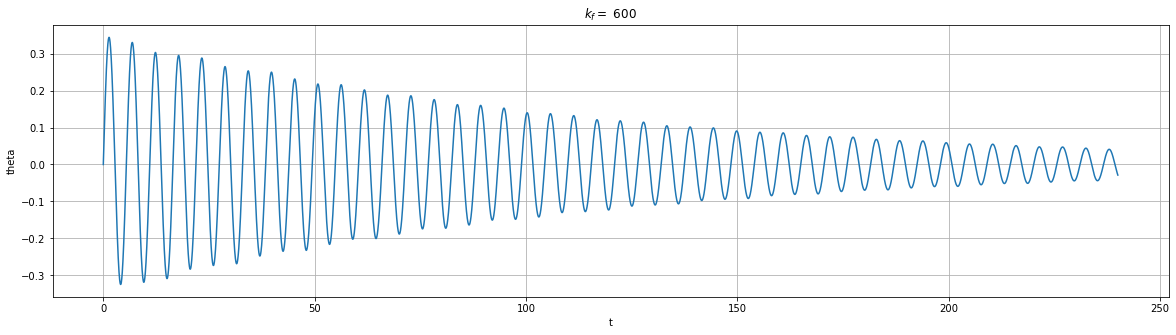

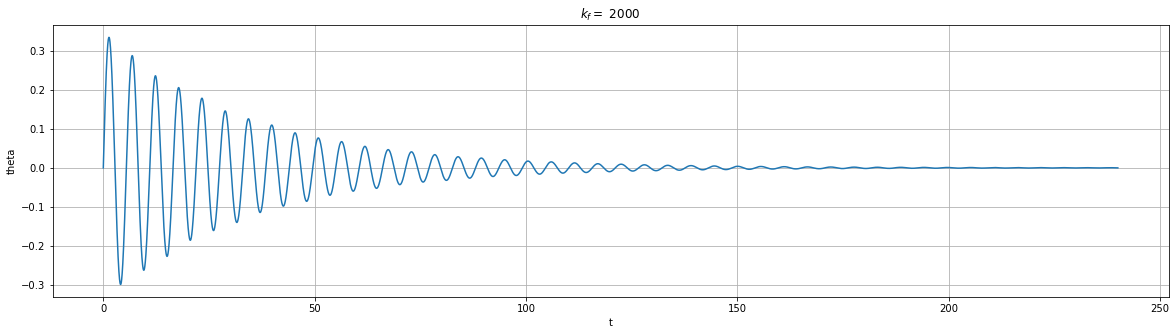

In [22]:

k_friction = 200

t,y=ode_solver(f_2f_try, t0_try, tend_try, w_vector_oppg2e, h=0.01, method=RK4)

plt.figure(figsize=(20, 5))
plt.plot(t,y[:, 0])
plt.title('$k_f =$ 200')
plt.xlabel('t')
plt.ylabel('theta')
plt.grid()
plt.show()

k_friction = 600

t,y=ode_solver(f_2f_try, t0_try, tend_try, w_vector_oppg2e, h=0.01, method=RK4)

plt.figure(figsize=(20, 5))
plt.plot(t,y[:, 0])
plt.title('$k_f =$ 600')
plt.xlabel('t')
plt.ylabel('theta')
plt.grid()
plt.show()

k_friction = 2000



t_vals_2g = np.linspace(0,240, int(240/0.01+1))

t,y=ode_solver(f_2f_try, t0_try, tend_try, w_vector_oppg2e, h=0.01, method=RK4)

plt.figure(figsize=(20, 5))
plt.plot(t,y[:, 0])
plt.title('$k_f =$ 2000')
plt.xlabel('t')
plt.ylabel('theta')
plt.grid()
plt.show()

Vi ser at friksjonskraften gjør at vinkelamplituden avtar cirka som en eksponensialfunksjon, som beskrevet i oppgaveteksten. Og ikke overraskende, fører større $k_f$ til sterkere demping.

Til slutt inkluderer vi vind- og bølgekraften som er en harmonisk kraft. Vi bruker parameterne og initalbetingelsene fra oppgaveteksten og undersøker resultatet.

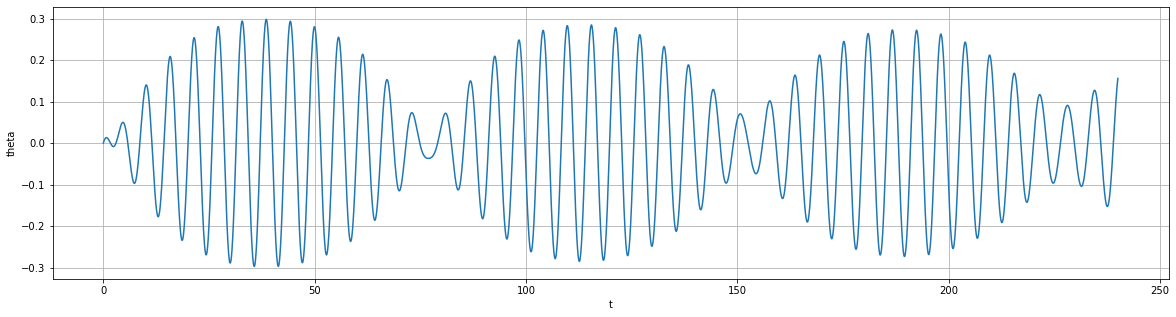

In [23]:

def f_2g_try(t, array):
    m_l=0*m_s
    m_tot = m_s + m_l
    s_last = array[7]
    theta_val = array[0]
    k_f=100

    w_freq = 0.93*np.sqrt(m_s*g*height/I_c) #frekvensen til innkommende bølge Rad/s
    
    F_0_wave = 0.625*m_s*g  #kraften fra bølgene

    y_diff = array[5] - y_c0
    gamma_val = gamma(array[5],array[0])
    

    if abs(array[7])>=R_s:
        m_l = 0
        
    else:
        v_last=array[6]
        a_last = - g*np.sin(theta_val)


    current_time = t
    y_pos=array[5]
    omega_val = array[1]

    torque = torque_complete(gamma_val,theta_val, m_l, s_last, w_freq, F_0_wave, current_time, y_pos, omega_val,k_f)


    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_tot) + f_B(gamma_val) + f_last_y(m_l, array[0])

    a_y = f_sum_y/m_tot

    f_sum_x =  f_last_x(m_l, theta_val) + f_waves_x(w_freq, F_0_wave, current_time) + f_friction_x(gamma_val, omega_val,k_f)
    a_x = f_sum_x/m_tot

   

    
    if gamma_val/2 > pi/2-abs(theta_val):
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, a_x, a_y, v_x, v_y, 0, 0])

        return dy

t0_try, tend_try = 0,240

#           0         1     2                      3                 4                          5                     6                7                       
#w_vektor=[tetta, omega, fart x_retning_båt, fart y_retning båt, posisjon x retning båt, posisjon y-retning båt,fart last på plan, posisjon last på plan]
w_vector_oppg2e=np.array([0,np.radians(2),0,0,0,y_C0,0,0])

t,y=ode_solver(f_2g_try, t0_try, tend_try, w_vector_oppg2e, h=0.01, method=RK4)
#plt.plot(t,y[:,5])

#plt.xlabel('t')
#plt.ylabel('$y_c$')
#plt.show()

#plt.plot(t,y[:,7])
#plt.grid()

plt.show()
plt.figure(figsize=(20, 5))
plt.xlabel('t')
plt.ylabel('theta')
plt.plot(t,y[:, 0])
plt.grid()
plt.show()


Vi ser fra figuren at det dukker opp sveving når vi plotter vinkelutslaget til båten. Sveving dukker opp når to bølger med veldig lik frekvens sammenfaller. I denne oppgaven er det bølgefrekvensen som er den primære ytre kraften vi ser på. Dersom bølgekraften hadde harmonert med egenfrekvensen til båten ville vi fått konstruktiv inteferens slik at båten ville tippet rundt. Fordi bølgekraften her har ganske lik, men ikke helt lik frekvens observerer vi sveving. Det kommer av at vi har lengre og vekslende perioder med konstruktiv og destruktiv inteferens. Hvis vi ser på båtens svingefrekvens der vi ser bort fra friksjonskrafta har vi forventet vinkelutslag uten bølgekraft $\sim cos(\omega_0 t)$ og et bidrag fra bølgekraft som er $\sim cos(0.93\omega_0 t)$. Fra identiteten $cos(A)+cos(B)=2cos(\frac{A+B}{2})cos(\frac{A-B}{2})$ kan vi forvente vinkelutslag $\sim cos(\frac{0.07\omega_0}{2})cos(\frac{1.93\omega_0}{2})$. Plotter vi dette vil vi observere sveving. Svevingen vil avta etter hvert på grunn av friksjonskraften.

Vi velger nå å implementere Bogacki-Shampine metoden for å teste ut dens egenskaper mot RK4. Bogacki-Shampine er en tredje ordens metode, med fire steg som går på "first same as last" prinsippet. Altså at siste funksjonsevalueringen i et steg er likt den første i det siste. Dette gjør at vi får fire funksjonsevalueringer, men trenger bare å regne ut tre. 

For å gjøre Bogacki-Shampine mer effektiv implementerer vi den med dens andre ordens metode. Vi kan med denne regne ut den lokalefeilen i steget. Da kan vi lage en adaptiv ODE-løser som kan velge å forkaste eller beholde et steg basert på den lokale feilen i forhold til tålegrensen i steget. Etter det justerer vi steget enten større hvis den lokale feilen er mindre enn tålegrensen, eller mindre hvis motsatt.

In [24]:
def bogshamp (f,t0, y0,h0,K_init): #tester bogshamp
    
    
    p=2
    
    k1 = f(t0, y0)
    k2 = f(t0+0.5*h0,y0+h0*0.5*k1)
    k3 = f(t0+0.75*h0,y0+h0*0.75*k2)
    y_next= y0 + h0*(2/9*k1+1/3*k2+4/9*k3)
    t_next = t0 + h0

    
    k4=f(t_next,y_next)
    
    z = y0[0] + h0 * (7/24 *K_init[0] + 1/4 * k2[0] + 1/3 * k3[0] + 1/8 * k4[0])
    
    err = norm(y_next[0]-z)
    
    
    
    return t_next, y_next, k4, err, p




In [25]:
def adaptive_ode_solver(pes,tol,f, t0, tend, y0, h, method=bogshamp): 
    #t_start = time()
    h_list = [h]
    #Initializing:
    y_num = np.array([y0])    # Array for the solution y 
    t_num = np.array([t0])    # Array for the x-values

    tn = t0                # Running values for x and y
    yn = y0 
    
    
    K4 = f(t0, y0)

    # Main loop
    while tn < tend - 1.e-10:           
        if tn + h > tend:                    
            h = tend - tn 
        tntry, yntry, K4, err, p = method(f, tn, yn,h, K4)
 
            
        if err <= tol :#Values are accepted
            yn = yntry
            tn = tntry
            y_num = np.concatenate((y_num, np.array([yn])))
            t_num = np.append(t_num,tn)
            h_list.append(h)
            
            
        h = 0.8*(tol/err)**(1/(p+1))*h
    #t_stop = time()
    #print ("runtime: ", t_stop-t_start)
    return t_num, y_num , h_list





For å teste ut de numeriske egenskapene til bogshamp bruker vi funksjonen for liten vinkeltilnærming i 1g). Og sammenligner den med den analytiskeløsningen av diffrensial likningen.

Bogshamp: 
runtime:  0.020678043365478516


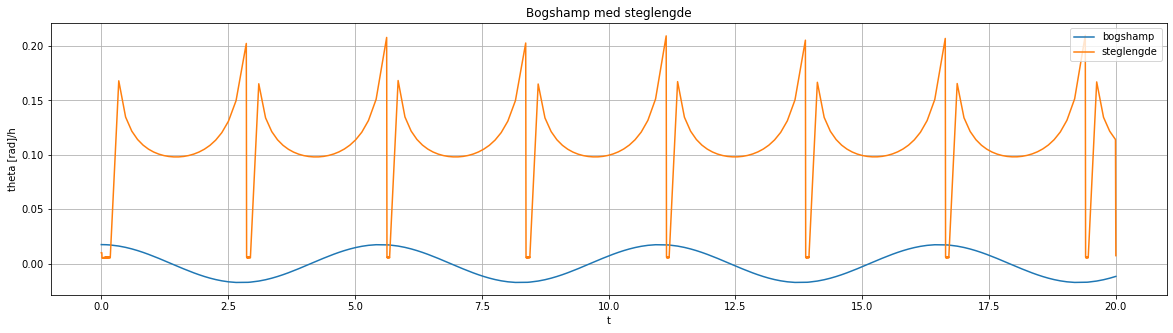

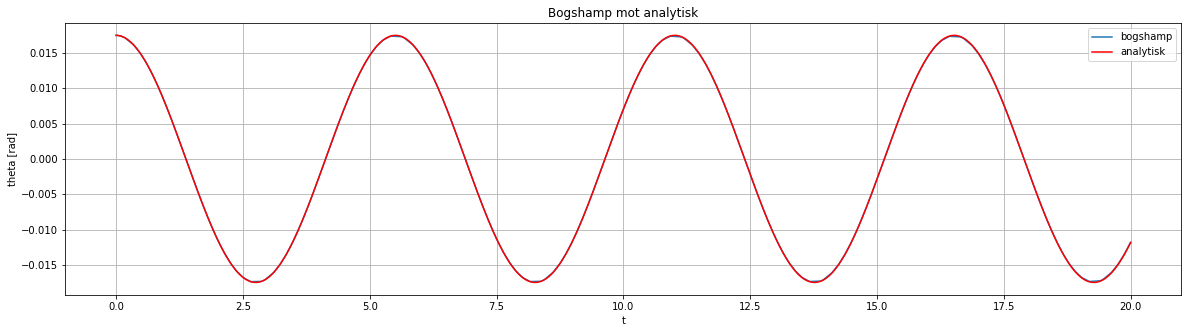

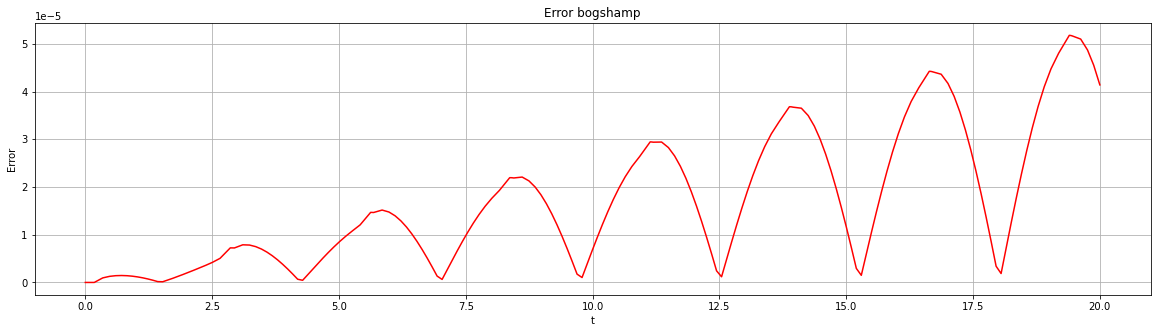

Max error bogshamp:  5.176919701511962e-05


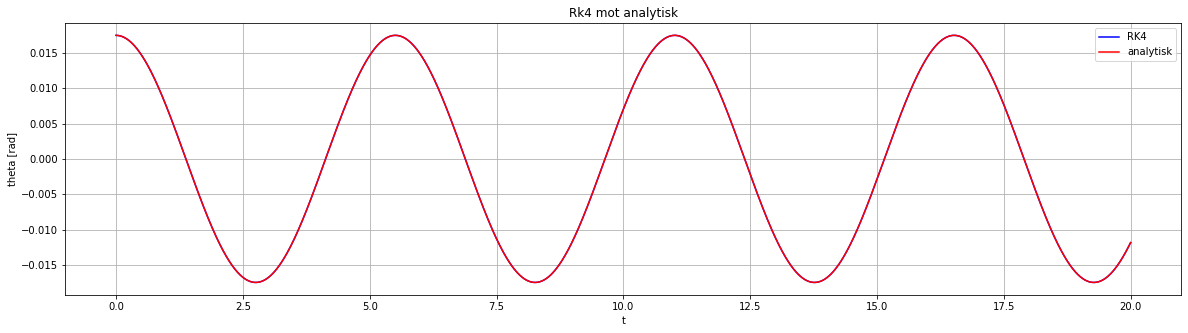

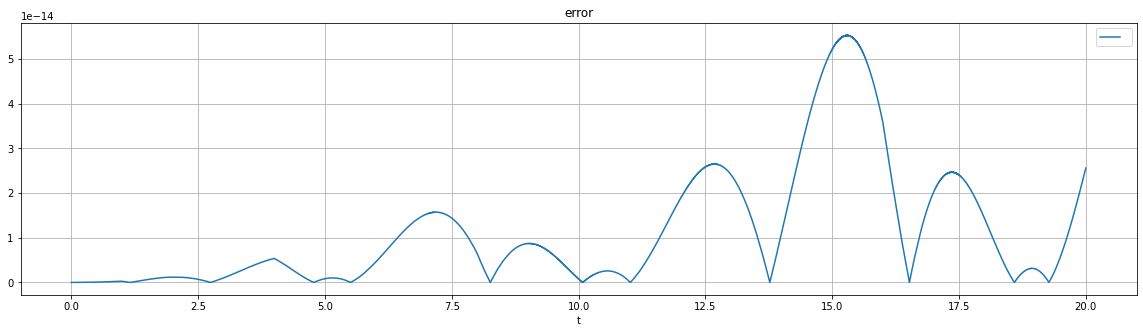

max error RK4:  5.527999932808392e-14


In [26]:
tend=20
w_vector_1g = np.array([np.radians(1), 0]) 
print("Bogshamp: ")
time_start = time()
t_bog,y_bog , h_list=adaptive_ode_solver(0.7,10**-6,f_approx, 0, tend,w_vector_1g,0.01, method=bogshamp)
print("runtime: ", time()-time_start)

fig=plt.figure(figsize=(20, 5))
plt.ylabel("theta [rad]/h")
plt.xlabel("t")
plt.plot(t_bog,y_bog[:,0])
plt.plot(t_bog,h_list)
plt.grid()
plt.title("Bogshamp med steglengde")
plt.legend(["bogshamp","steglengde"],loc=1)
plt.show


fig=plt.figure(figsize=(20, 5))
plt.ylabel("theta [rad]")
plt.xlabel("t")
plt.plot(t_bog,y_bog[:,0])
plt.grid()
plt.plot(t_1g, g_analytic,'r')
plt.legend(["bogshamp","analytisk"],loc=1)
plt.title("Bogshamp mot analytisk")
plt.show()

analytic_bog = analytic_1g(t_bog, np.radians(1))
error_bog = abs(y_bog[:,0] - analytic_bog)

fig=plt.figure(figsize=(20, 5))
plt.ylabel("Error")
plt.xlabel("t")
plt.grid()
plt.plot(t_bog, error_bog,'r')
plt.title("Error bogshamp")
plt.show()

print("Max error bogshamp: ", np.abs(np.amax(error_bog)))


fig=plt.figure(figsize=(20, 5))
plt.ylabel("theta [rad]")
plt.xlabel("t")
plt.plot(t_1g, theta_1g,'b')
plt.plot(t_1g, g_analytic,'r')
plt.grid()
plt.title('Rk4 mot analytisk')
plt.xlabel('t')
plt.legend(['',''],loc=1)
plt.legend(["RK4","analytisk"],loc=1)
plt.show()

fig=plt.figure(figsize=(20, 5))
error_1g =  abs(theta_1g - g_analytic)
plt.plot(t_1g, error_1g)
plt.xlabel('t')
plt.grid()
plt.title('error')
plt.legend(['',''],loc=1);
plt.show()

print ("max error RK4: ", np.abs(np.amax(error_1g)))




Vi ser at RK4 er i orden $$10^{-14} $$ i feilen i den numeriske tilnærmingen, mens Bogacki-Shampine er i orden $$ 10^{-5} $$. Bogshamp er i gjengeld raskere enn RK4. Dette skyldes både at den er adaptiv og at den er en orden tre metode, som i praksis bruker kun tre funksjonsvurderinger. 

Skal man løse en ODE der nøyaktigheten er viktig burde man valg RK4 over Bogacki-Shampine. Men i denne oppgaven der vi er mer opptatt av hvordan båtens bevegelser ville sett ut, der vi allerede har gjort noen store forenklinger, særlig i de fluidmekaniske egenskapene til vannet, er Bogshamp en god nok tilnærmelse til å observere dette. At vi bommer med noen grader i utfallsvinklene har ikke så mye å si.

Vi skal nå prøve å finne egenfrekvensen til systemet. Med liten vinkel tilnærming og den løste ODE-en fra 1 e) har vi at $$ \omega_{0} = \sqrt{\frac{m_{s}gh}{I_{c}}} $$.
Man kan anta at egenfrekvensen i vårt tilfelle vil være rundt denne frekvensen. Derfor regner vi ut egenfrekvensen på formen : $$ \omega_{0} =n \sqrt{\frac{m_{s}gh}{I_{c}}} $$
Hvor $$ n \epsilon R$$ vi antar at n er rundt 1.

For å finne egenfrekvensen utnytter vi bølgefrekvensen $$ \omega_{w} $$. Lar vi bølgekraften være stor nok i forhold til friksjonen kan vi variere $$ \omega_{w} $$ slik at når den er i nærheten av egenfrekvensen til systemet vil bølgekraften kantre skipet. Det eneste vi trenger å gjøre for å finne egenfrekvensen da er å løse difrensiallikningen til systemet beskrevet i f_2h_kreativ for en mengde forskjellige bølgefrekvenser rundt analytisk egenfrekvensen. Vi velger å teste for 30 forskjellige bølgefrekvenser i RK4 og 60 i bogshamp. For begge tester vi i området $$[0.95\omega_{0anal},1.1\omega_{0anal}] $$

Først definerer vi funksjonen som kan ta inn varierende bølgefrekvenser.
Vi lar massen til lasten fortsatt være 0. Friksjonskoeffsienten justerer vi ned til 10, og krata fra bølgene ned til 0.435*M_s*g.

In [27]:
def f_2h_kreativ(t, array):
    m_l=0*m_s
    m_tot = m_s + m_l
    #print(array)
    s_last = array[7]
    theta_val = array[0]
    k_f=10

    w_freq = freq*np.sqrt(m_s*g*height/I_c) #frekvensen til innkommende bølge Rad/s freq*analytisk egenfrekvens
    F_0_wave =0.435 *m_s*g  #kraften fra bølgene

    y_diff = array[5] - y_c0
    #print(y_diff)
    gamma_val = gamma(array[5],array[0])
    

    if abs(array[7])>=R_s:
        m_l = 0
        
    else:
        v_last=array[6]
        a_last = - g*np.sin(theta_val)


    current_time = t
    y_pos=array[5]
    omega_val = array[1]

    torque = torque_complete(gamma_val,theta_val, m_l, s_last, w_freq, F_0_wave, current_time, y_pos, omega_val,k_f)

    #print(torque_B(gamma_val, theta_val))

    v_x = array[2]
    v_y = array[3]
    
    f_sum_y = f_g(m_tot) + f_B(gamma_val) + f_last_y(m_l, array[0])

    a_y = f_sum_y/m_tot
    #print(a_y)

    f_sum_x =  f_last_x(m_l, theta_val) + f_waves_x(w_freq, F_0_wave, current_time) + f_friction_x(gamma_val, omega_val,k_f)
    a_x = f_sum_x/m_tot

    r_last = s_last/np.cos(theta_val) #avstand fra massesenter til last
    #tar ikke høyde for at massesenteret flytter seg litt for da vil alle uttrykkene for dreiemoment endre seg

    
    if gamma_val/2 > pi/2-abs(theta_val):
        
        return np.array([np.sign(array[0])*pi/2, 0,0,0,0,0,0,0])
    else:
        dy = np.array([array[1], torque/I_c, a_x, a_y, v_x, v_y, 0, 0])

        return dy
    

Så bruker vi Bogacki-Shampine og RK4 for å finne bølgefrekvensene der båten kantrer.

Når vi har truffet et området med $$\omega_{w} \approx \omega_{0} $$ lagrer vi verdiene båten kantrer får. Vi vil ikke finne nye bølgefrekvenser der båten kantrer etter dette området. Så for å kutte ned på kjøretid stopper vi å
teste for flere $$\omega_{w}$$.

<ipython-input-25-cc8caa63170d>:29: RuntimeWarning: divide by zero encountered in double_scalars
  h = 0.8*(tol/err)**(1/(p+1))*h


For bølgefrekvenser mellom 1.1331448828757267  til  1.1592497564573347  kantrer båten




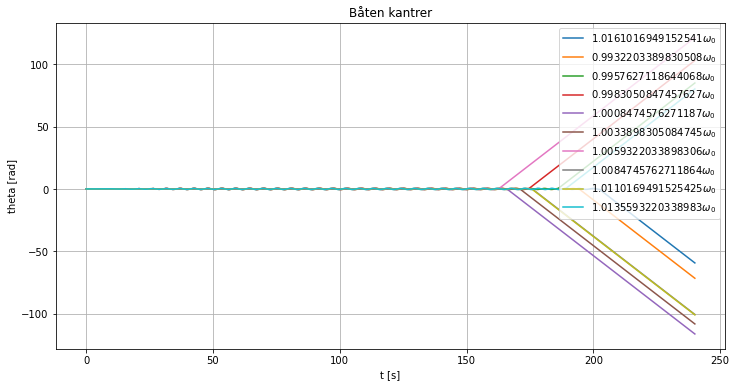

analytisk egenfrekvens:  1.1408796602332403
runtime:  79.65670275688171


In [28]:
#Bogshamp tilnærming for å finne egenfrekvens:

time_start=time()

w_vector_oppg2h_kreativ=np.array([0,0,0,0,0,y_c0,0,0]) #setter alle startverdier lik 0
tend=240


    
freq_list = np.linspace(0.95,1.1,60) #Tester for freqvenser rundt den analytiske egenfrekvensen
eigen_frequences = [] #liste med bølgefrekvenser der båten kantrer
k=0 #hjelpe konstant for å stoppe kjøringa når vi ikke lenger kantrer
helper = 1 #hjelpe konstant for å stoppe kjøringa når vi ikke lenger kantrer
frequences_list = [] #array som skal fylles opp med alle y og t verdier

for freq in freq_list:

    t_bog_creative,y_bog_creative , h_list=adaptive_ode_solver(0.7,10**-6,f_2h_kreativ, 0, tend,w_vector_oppg2h_kreativ,0.01, method=bogshamp)
    if np.abs(y_bog_creative[:,0][-1])>50: #lagrer alle frekvenser, og [t,theta] der båten kantrer
        eigen_frequences.append(freq)
        k+=1
        helper=0
        frequences_list.append( [t_bog_creative,y_bog_creative[:,0]] )
        
    elif (k>0 and helper==0): #Breaker hvis vi går fra at båten kantrer til den ikke kantrer lenger
        break
        
print("For bølgefrekvenser mellom",eigen_frequences[0]*np.sqrt(m_s*g*height/I_c)," til ", eigen_frequences[-1]*np.sqrt(m_s*g*height/I_c), " kantrer båten")




print() 
print()
    

#fig=plt.figure(figsize=(240, 5))
plt.ylabel("theta [rad]")
plt.xlabel("t [s]")
for i in range(k):
    frekvens_konst=eigen_frequences[i-1]
    plt.plot(frequences_list[i-1][0],frequences_list[i-1][1], label = f"{frekvens_konst}$\omega_{0}$" )
plt.grid()
plt.title("Båten kantrer")
plt.legend()
plt.show()
 
    


    

print("analytisk egenfrekvens: ", np.sqrt(m_s*g*height/I_c))

print("runtime: ", time()-time_start)

For bølgefrekvenser mellom 1.1369455924393326  til  1.1546488975119173  kantrer båten




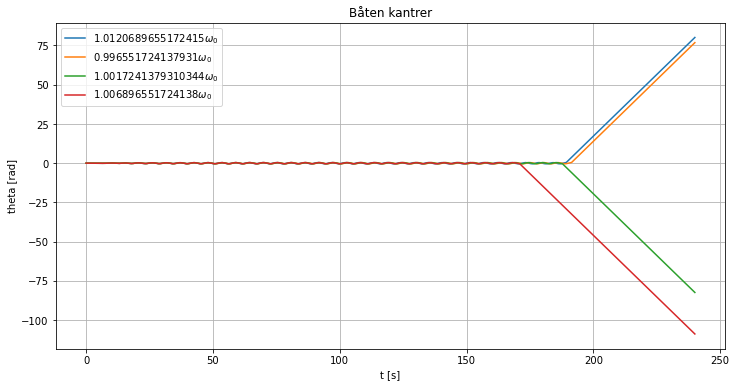

analytisk egenfrekvens:  1.1408796602332403
runtime:  78.39547801017761


In [29]:
#RK4

time_start=time()


    
freq_list_rk4 = np.linspace(0.95,1.1,30) #Tester for freqvenser rundt den analytiske egenfrekvensen
eigen_frequences_rk4 = [] #liste med bølgefrekvenser der båten kantrer
k_rk4=0 #hjelpe konstant for å stoppe kjøringa når vi ikke lenger kantrer
helper_rk4 = 1 #hjelpe konstant for å stoppe kjøringa når vi ikke lenger kantrer
frequences_list_rk4 = [] #array som skal fylles opp med alle y og t verdier

for freq in freq_list_rk4:

    t_rk4_creative,y_rk4_creative=ode_solver(f_2h_kreativ, 0, tend,w_vector_oppg2h_kreativ, h=0.01, method=RK4)
    if np.abs(y_rk4_creative[:,0][-1])>50: #lagrer alle frekvenser, og [t,theta] der båten kantrer
        eigen_frequences_rk4.append(freq)
        k_rk4+=1
        helper_rk4=0
        frequences_list_rk4.append( [t_rk4_creative,y_rk4_creative[:,0]] )
        
    elif (k_rk4>0 and helper_rk4==0): #Breaker hvis vi går fra at båten kantrer til den ikke kantrer lenger
        break
        
print("For bølgefrekvenser mellom",eigen_frequences_rk4[0]*np.sqrt(m_s*g*height/I_c)," til ", eigen_frequences_rk4[-1]*np.sqrt(m_s*g*height/I_c), " kantrer båten")




print() 
print()
    

#fig=plt.figure(figsize=(240, 5))
plt.ylabel("theta [rad]")
plt.xlabel("t [s]")
for i in range(k_rk4):
    frekvens_konst=eigen_frequences_rk4[i-1]
    plt.plot(frequences_list_rk4[i-1][0],frequences_list_rk4[i-1][1], label = f"{frekvens_konst}$\omega_{0}$" )
plt.grid()
plt.title("Båten kantrer")
plt.legend()
plt.show()
 
    


    

print("analytisk egenfrekvens: ", np.sqrt(m_s*g*height/I_c))

print("runtime: ", time()-time_start)

Vi ser at for $$ \omega_{w} = [1.0059\omega_{0anal},1.0069\omega_{0anal}] $$ kantret båten først. Derfor antar vi at $$\omega_{0} $$ vil mellom disse verdiene.

På grunn av at Bogacki-Shampine kjører i overkant av dobbel så fort som RK4, valgte vi å teste for dobbelt så mange bølgefrekvenser med den. Siden steglengden mellom $$ \omega_{w}$$ er $$\approx0.005$$ mens den numeriske feilen i Bogshamp og RK4 er henholdsvis i orden $$ 10^{-5} $$ og $$ 10^{-14} $$ Er begge metodene nøyaktige nok for å finne  den verdien av $$ \omega_{w}$$ som er nærmest $$\omega_{0}$$ for verdiene vi iterer over. Det at Bogacki-Shampine er så raskt at vi kan iterere over flere $$\omega_{w}$$ gjør da at den blir mest nøyaktig.

Det er naturlig at vi får en egenfrekvens nært den analytiske egenfrekvensen.
Egenfrekvensen er en fundamental egenskap for systemet, og den er den samme selv om båten har store eller små vinkelutslag. Hvis vi ser bort i fra frekvensen kan vi anta at egenfrekvensen ville vært den samme med liten vinkel tilnærming som uten $$\omega_{0} = \omega_{0anal} $$. Men siden vi har en friksjon får vi en dempet svingning 
$$ \theta(t) = \theta_{0}e^{-\delta t}\sin(\omega_{0} t) $$. Med vinkelfrekvens 
$$ \omega_{0} = \sqrt{\omega_{0anal}^{2} - \delta^{2}} $$ Når da bølgekraften er tilstreklig stor slik at dempingen $$\delta$$ blir veldig liten får vi at $$ \omega_{0} \approx {\omega_{0anal}} $$


# Konklusjon

Denne rapporten har vært todelt. Vi har simulert og testet de ulike faktorene som fikk Vasaskipet til å synke. Samt testet ulike numeriske metoder opp mot hverandre. 

Faktorene vi har testet har hatt ulik innvirkning på stabiliteten til skipet. Last og bølger fører til kantring under visse omstendigheter. Mens friksjonen i vannet som forventet gjør båten mer stabil, ettersom den demper vinkelfarten. Vi har også sett på egenfrekvensen til skipet, og vist at ved bølger rundt denne frekvensen kan skipet kantre selv om bølgene ikke er spesielt sterke. 
I virkeligheten er det veldig mange flere faktorer som på virker skipet, som mer komplisert form, 3 dimensjoner, og bevegelsen i vannet forårsaket av skipet. 

De numeriske metodene vi har testet er Euler-metoden, Runge-Kutta 4 og Bogacki-Shampine. Det viste seg å være store ulikheter i den numeriske feilen blant disse metodene. Men som vi så i siste oppgave er det ikke nødvendigvis den mest nøyaktige metoden som alltid er best. Man må alltid veie fordelen av nøyaktighet mot kjøretid og hvor vanskelig det er å implementere metoden. 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=211ae38d-f291-4e7e-ae53-230aa41d2d04' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>